In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

/home/charlesohanlon/miniconda3/envs/pytorch_getting_started/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/charlesohanlon/miniconda3/envs/pytorch_getting_started/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [147]:
imagenet_transform = transforms.Compose([
    # crop random 256 x 256 subsection of image
    transforms.RandomResizedCrop(256),
    # convert PIL to (C x H x W) tensor and normalize values
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.spawn(device))
])

label_to_one_hot_transform = transforms.Lambda(lambda x: nn.functional.one_hot(torch.tensor([x]).to(device), num_classes=1000))

In [129]:
root_of_train = "/home/charlesohanlon/Development/Datasets/ImageNet/Data/train"
root_of_test = "/home/charlesohanlon/Development/Datasets/ImageNet/Data/test"

train_dataset = datasets.ImageFolder(
    root=root_of_train,
    transform=imagenet_transform,
    # put labels in one-hot encoded form
    target_transform=label_to_one_hot_transform
)

test_dataset = datasets.ImageFolder(
    root=root_of_test,
    transform=imagenet_transform,
    target_transform=label_to_one_hot_transform
)

In [130]:
import json

with open("/home/charlesohanlon/Development/pytorch_getting_started/id2class.json", "r") as id2class:
    folder2info = json.load(id2class)
    class2name = {folder2info[folder][1]:folder2info[folder][0] for folder in folder2info}


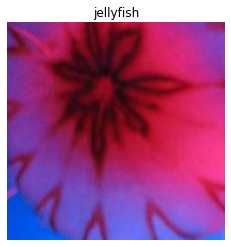

In [131]:
import random
random_idx = random.randint(0, len(train_dataset) - 1)
img, one_hot_pred = train_dataset[random_idx]
label = torch.argmax(one_hot_pred).item()
img_arr = np.transpose(np.asarray(img.cpu()), axes=(1, 2, 0))

plt.title(class2name[label])
plt.imshow(img_arr)
plt.axis("off")
plt.show()

In [133]:
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape (None, 3, 256, 256)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2)
        nn.init.kaiming_uniform_(self.conv1.weight)

        # input shape (None, 64, 125, 125)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2)

        # input shape (None, 64, 62, 62)
        self.conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
        )
        nn.init.kaiming_uniform_(self.conv2_1[0].weight)
        nn.init.kaiming_uniform_(self.conv2_1[3].weight)

        # input shape (None, 64, 62, 62)
        self.conv2_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
        )
        nn.init.kaiming_uniform_(self.conv2_2[0].weight)
        nn.init.kaiming_uniform_(self.conv2_2[3].weight)

        # input shape (None, 64, 62, 62)
        self.conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
        )
        nn.init.kaiming_uniform_(self.conv3_1[0].weight)
        nn.init.kaiming_uniform_(self.conv3_1[3].weight)

        # input shape (None, 64, 62, 62)
        self.transition_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        nn.init.kaiming_uniform_(self.transition_conv3.weight)

        # input shape (None, 128, 30, 30)
        self.conv3_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
        )
        nn.init.kaiming_uniform_(self.conv3_2[0].weight)
        nn.init.kaiming_uniform_(self.conv3_2[3].weight)

        # input shape (None, 128, 30, 30)
        self.conv4_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
        )
        nn.init.kaiming_uniform_(self.conv4_1[0].weight)
        nn.init.kaiming_uniform_(self.conv4_1[3].weight)

        # input shape (None, 128, 30, 30)
        self.transition_conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2)
        nn.init.kaiming_uniform_(self.transition_conv4.weight)

        # input shape (None, 256, 14, 14)
        self.conv4_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
        )
        nn.init.kaiming_uniform_(self.conv4_2[0].weight)
        nn.init.kaiming_uniform_(self.conv4_2[3].weight)

        # input shape (None, 256, 14, 14)
        self.conv5_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
        )
        nn.init.kaiming_uniform_(self.conv5_1[0].weight)
        nn.init.kaiming_uniform_(self.conv5_1[3].weight)

        # input shape (None, 256, 14, 14)
        self.transition_conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2)
        nn.init.kaiming_uniform_(self.transition_conv5.weight)

        # input shape (None, 512, 6, 6)
        self.conv5_2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
        ) 
        nn.init.kaiming_uniform_(self.conv5_2[0].weight)
        nn.init.kaiming_uniform_(self.conv5_2[3].weight)

        # input shape (None, 512, 6, 6)
        self.avg_pool = nn.AvgPool2d(kernel_size=3, stride=1)

        # input shape (None, 512, 4, 4)
        self.flatten = nn.Flatten()

        # input shape (None, 8192, 1)
        self.fc = nn.Linear(in_features=8192, out_features=1000, bias=True)
        nn.init.kaiming_uniform_(self.fc.weight)

    
    def forward(self, X):
        conv1 = self.conv1(X)

        max_pool = self.max_pool(conv1)

        conv2_1 = self.conv2_1(max_pool)

        conv2_2 = self.conv2_2(conv2_1 + max_pool)

        conv3_1 = self.conv3_1(conv2_2 + conv2_1)

        conv3_2 = self.conv3_2(conv3_1 + self.transition_conv3(conv2_2))

        conv4_1 = self.conv4_1(conv3_2 + conv3_1)

        conv4_2 = self.conv4_2(conv4_1 + self.transition_conv4(conv3_2))

        conv5_1 = self.conv5_1(conv4_2 + conv4_1)

        conv5_2 = self.conv5_2(conv5_1 + self.transition_conv5(conv4_2))

        avg_pool = self.avg_pool(conv5_2)
        
        logits = self.flatten(avg_pool)

        logits = self.fc(logits)

        pred = nn.Softmax(dim=-1)(logits)

        return pred



In [132]:
batch_size = 256
epochs = 35
learning_rate = 0.1

In [136]:
from torchinfo import summary
model = ResNet18().to(device)
# print(summary(model, input_size=(batch_size, 3, 256, 256)))

In [142]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=8, pin_memory=True)

In [144]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)

In [143]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss = loss.item()

            # number of examples trained on so far
            current = (batch + 1) * len(X)

            print(f"loss: {loss:>7} [{current:>5d}/{size:>5d}]")


In [145]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            avg_loss += loss_fn(X, y).item()
            accuracy += (pred.argmax(dim=1) == y.argmax(dim=1)).type(torch.float).item()
    
    avg_loss /= num_batches
    accuracy /= size
    print(f"Test Error:\n Accuracy: {(100 * correct):>0.1f}%, Avg Loss: {test_loss:>8f}\n")
    


In [148]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, scheduler)
    test_loop(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/charlesohanlon/miniconda3/envs/pytorch_getting_started/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/charlesohanlon/miniconda3/envs/pytorch_getting_started/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/charlesohanlon/miniconda3/envs/pytorch_getting_started/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/home/charlesohanlon/miniconda3/envs/pytorch_getting_started/lib/python3.11/site-packages/torchvision/datasets/folder.py", line 231, in __getitem__
    sample = self.transform(sample)
             ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/charlesohanlon/miniconda3/envs/pytorch_getting_started/lib/python3.11/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
          ^^^^^^
  File "/home/charlesohanlon/miniconda3/envs/pytorch_getting_started/lib/python3.11/site-packages/torchvision/transforms/transforms.py", line 486, in __call__
    return self.lambd(img)
           ^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1814/2405172539.py", line 6, in <lambda>
    transforms.Lambda(lambda x: x.to(device))
                                ^^^^^^^^^^^^
  File "/home/charlesohanlon/miniconda3/envs/pytorch_getting_started/lib/python3.11/site-packages/torch/cuda/__init__.py", line 235, in _lazy_init
    raise RuntimeError(
RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
